In [1]:
# dataloader code
from unet import *
from segmentation_dataset import SegmentationDataset

import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from loguru import logger
import random

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm, trange

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

train_path = "small_dataset/images/nir/"
val_path = "small_dataset/images/nir/"
test_path = "small_dataset/images/nir/"

train_labels_path = "small_dataset/labels/"
val_labels_path = "small_dataset/labels/"
test_labels_path = "small_dataset/labels/"

train = os.listdir(train_path)
val = os.listdir(val_path)
test = os.listdir(test_path)

random.shuffle(train)
random.shuffle(val)
random.shuffle(test)

train_img_names_index = train[:10]
val_img_names_index = val[:10]
test_img_names_index = test[:10]

labels_one_hot = {}
k = 8
i=0
for label in listdir_nohidden(train_labels_path):
    if label!="storm_damage":
        labels_one_hot[label] = np.zeros((k,))
        labels_one_hot[label][i] = 1
        i+=1

train_dataset = SegmentationDataset("train", train_img_names_index, labels_one_hot, train_path, train_labels_path, use_cache=True)
val_dataset = SegmentationDataset("validation", val_img_names_index, labels_one_hot, val_path, val_labels_path, use_cache=True)
test_dataset = SegmentationDataset("test", test_img_names_index, labels_one_hot, test_path, test_labels_path, use_cache=True)

2021-05-26 13:41:18.972 | INFO     | segmentation_dataset:__init__:27 - Reading train image 0 out of 10
2021-05-26 13:41:19.110 | INFO     | segmentation_dataset:__init__:27 - Reading validation image 0 out of 10
2021-05-26 13:41:19.227 | INFO     | segmentation_dataset:__init__:27 - Reading test image 0 out of 10


In [2]:
# SETTINGS
Use_GPU = True
Lr = 1e-3
channels = 1  # NIR vs RGB
classes = 9  # outputs (9 labels + 1 background)
maxEpochs = 10
batch_size = 5
shuffle = True

# Code 
if Use_GPU: 
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda used')
    else:
        device = torch.device('cpu')
else:
    device = torch.device('cpu')
# initalize model 

# fix activationfunc, dropout and other settings for model as parameters later 

model = UNet(channels, classes).to(device)

trainValRate = 0.7  # not in use
lrRatesplan = None  # not in use
activation = "relu"  # not in use 

class_weights = torch.FloatTensor([1]+[5]*8)#.cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = torch.nn.CrossEntropyLoss()#ignore_index=0)
optimizer = torch.optim.SGD(model.parameters(), Lr)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

cuda used


In [3]:
trainingAcc = []
trainingLoss = []
validationAcc = []
validationLoss = []

def itterProgress(x, text = "training"):
    return tqdm(enumerate(x), text, total = len(x))

def run(): 
    # itter = itterProgress(trainX)

    for epoch in range(maxEpochs):
        train(epoch)

    torch.save(model.state_dict(), "trained_model.pth")
    

def train(epoch):
    model.train()
    for i, (batch_x, batch_y) in enumerate(train_dataloader):
        indata, target = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        indata = indata.unsqueeze(1)
        out = model(indata)
        out_softmax = torch.softmax(out, 1)
        img = postprocess(out_softmax)
        
        train_acc = iou(img, target)
        loss = criterion(out, target)
        train_loss = loss.item()
        
        trainingAcc.append(train_acc)
        trainingLoss.append(train_loss)

        loss.backward()
        optimizer.step()

        val_acc, val_loss = validate()

        validationAcc.append(val_acc)
        validationLoss.append(val_loss)

        logger.info(f"Epoch {epoch} batch {i+1}/{len(train_dataloader)} loss={train_loss} acc={train_acc} val_loss={val_loss} val_acc={val_acc}")

        if val_loss > np.mean(validationLoss):
            print("Overfitting detected")
            break

def validate():
    model.eval()
    validationAcc_temp = []
    validationLoss_temp = []
    for i, (batch_x, batch_y) in enumerate(val_dataloader):
        indata, target = batch_x.to(device), batch_y.to(device)
        
        with torch.no_grad():
            indata = indata.unsqueeze(1)
            out = model.forward(indata)
            out_softmax = torch.softmax(out, 1)
            img = postprocess(out_softmax)
            
            val_acc = iou(img, target)            
            loss = criterion(out, target)
            val_loss = loss.item()

            validationAcc_temp.append(val_acc)
            validationLoss_temp.append(val_loss)
    
    return np.mean(validationAcc_temp),np.mean(validationLoss_temp)

def postprocess(img):
    img = torch.argmax(img, dim=1)
    img = img.cpu().numpy()
    img = np.squeeze(img)
    img = torch.from_numpy(img).type(torch.int64)
    img = img.to(device)
    # img = re_normalize(img)
    return img

def iou(prediction, target):
    eps = 0
    score = 0

    for k in range(1, 10):
        intersection = torch.sum((prediction==target) * (target==k)).item()
        union = torch.sum(prediction==k).item() + torch.sum(target==k).item()
        iou_k = 0 if intersection == 0 else (intersection + eps) / (union + eps)
        score += iou_k

    score = score / 9
    return score

In [ ]:
run()

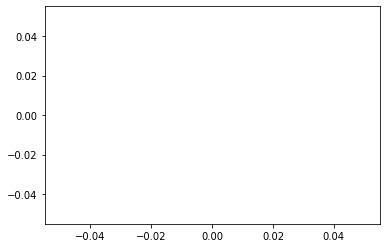

In [4]:
import matplotlib.pyplot as plt
plt.plot(validationLoss)
plt.plot(trainingLoss)

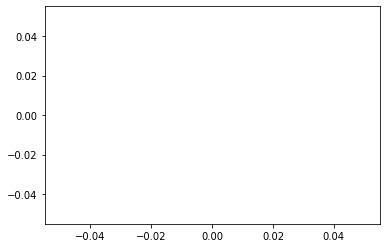

In [5]:
import matplotlib.pyplot as plt
plt.plot(validationAcc)
plt.plot(trainingAcc)

In [25]:
PATH = 'trained_model_18.pth'
model.to(torch.device('cuda'))
model.load_state_dict(torch.load(PATH, map_location=device),  strict=False)

# model.load_state_dict(checkpoint['state_dict'], strict=False)

def model_val():
    model.eval()

    for i, (batch_x, batch_y) in enumerate(val_dataloader):
        indata, target = batch_x.to(device), batch_y.to(device)
        
        with torch.no_grad():
            indata = indata.unsqueeze(1)
            out = model.forward(indata)
            out_softmax = torch.softmax(out, 1)
            img = postprocess(out_softmax)
            
            val_acc = iou(img, target)
            
            
            
            loss = criterion(out, target)
            val_loss = loss.item()

            print('acc={%f}, loss={%f}' % (val_acc, val_loss))

            print_target_vs_out(target, img, indata.squeeze(1))


def print_target_vs_out(target, outimg, x):
    n_batch = x.shape[0]
    fig = plt.figure()
    for i in range(x.shape[0]):
        ax1 = fig.add_subplot(n_batch, 3, i * 3 + 1)
        ax1.imshow(x[i], cmap="gray")
        ax2 = fig.add_subplot(n_batch, 3, i * 3 + 2)
        ax2.imshow(target[i], cmap="gray")
        ax3 = fig.add_subplot(n_batch, 3, i * 3 + 3)
        ax3.imshow(outimg[i], cmap="gray") 
    fig.show()
           
model_val()

RuntimeError: Expected object of device type cuda but got device type cpu for argument #3 'weight' in call to _thnn_nll_loss2d_forward